In [4]:
import os
import h5py
import numpy
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import time
from scipy.signal import savgol_filter
from scipy.io import loadmat
%matplotlib qt5

In [10]:
def matlab_timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromordinal(int(i) - 366) + timedelta(days=i%1) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromtimestamp(i) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def zscore(array):
    mean = array.mean()
    std = np.std(array)
    return((array-mean)/std)

def ms_from_start(datetimes):
    return(((datetimes-datetimes[0])/1000).astype(np.float64))

def get_mean_brightness(h5file, inds):
    lefts, rights = [], []
    for ind in inds:
        left = cv2.imdecode(h5file['left'][ind],0)
        right =  cv2.imdecode(h5file['right'][ind],0)
        lefts.append(left.mean())
        rights.append(right.mean())
    return(np.vstack((lefts, rights)).mean(axis=0))

def calculate_hist(array,binedges):
    binedges[0] = -np.inf
    binedges[-1] = np.inf
    histogram, bin_edges = np.histogram(array,binedges)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    return(histogram,bincenters)

def smooth(array, window_size=5):
    assert(window_size%2==1)
    filt = np.ones(window_size)/window_size
    # print(filt.sum())
    assert(abs(filt.sum()-1)<1e-6)
    
    return(np.convolve(array,filt, mode='same'))

def align_cameras_on_timestamps(filelist,master='right_post', WINDOW_SIZE=500,
                               use_window=True,max_distance=8):
    # WINDOW_SIZE=500
    # max_distance = 6 # ms
    
    frames = {}
    timestamps = {}
    sestimes = {}
    # filelist.sort()
    for key, file in filelist.items():
        if not file.endswith('t.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
            sestime = f['sestime'][:]
        # key = os.path.basename(file)[:-3]
        frames[key] = framecounts
        timestamps[key] = timestamp
        sestimes[key]  = sestime
    N = len(frames[master])
    camera_LUT = np.array((N,len(frames)), dtype=np.uint64)
    slaves = [i for i in list(frames.keys()) if i!=master]
    N = len(frames[master])
    camera_LUT = np.zeros((N,len(frames)), dtype=np.float64)
    
    for i in range(0,N):
        camera_LUT[i,0] = i
        t = timestamps[master][i]
        min_search = max(0,i-WINDOW_SIZE)
        
        for j, slave in enumerate(slaves):
            max_search = min(len(frames[slave]),i+WINDOW_SIZE)
            # happens when there are large differences in numbers of images between two files
            # this likely means the master has way more images than the slave
            if max_search<=min_search:
                camera_LUT[i,j+1]=np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[slave][min_search:max_search]-t).astype(np.float32)/1000)
                
            else:
                snippet = np.abs((timestamps[slave]-t).astype(np.float32)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            
            if mint < max_distance:
                val = argmin + min_search
            else:
                val = np.nan
            
            camera_LUT[i,j+1] = val
    
    # data = np.hstack((camera_LUT, timestamps[master]))
    df = pd.DataFrame(camera_LUT, columns=[master]+slaves)
    df['timestamps'] = timestamps[master]
    
    return(df)


def get_timestamps(virmendir, realsensedir):
    timestamps = {}
    
    # get virmen data as a dictionary
    virfiles = os.listdir(virmendir)
    virfiles.sort()
    varnames_file = [os.path.join(virmendir, i) for i in virfiles if 
                    'BinaryVariableNames' in i][0]
    
    mat = loadmat(varnames_file,squeeze_me=True)
    varnames = mat['saveOnIter']
    variables = []
    cnt=0
    for entry in varnames:
        name, n = entry
        if n > 1:
            for i in range(n):
                variables.append('%s%d' %(name,i))
        else:
            variables.append(name)
    binary_file = [os.path.join(virmendir, i) for i in virfiles if 
                  'iterBinary.bin' in i][0]
    rawdata = np.fromfile(binary_file, dtype=np.float64).reshape(-1,len(variables))
    data = {key:rawdata[:,i] for i,key in enumerate(variables)}
    timestamps['virmen'] = matlab_timestamp_to_numpy(data['timeStamp'])
    
    files = os.listdir(realsensedir)
    files.sort()
    
    eye_datafile = [os.path.join(realsensedir, i) for i in files if 'eyeData.mat' in i][0]
    eyedata = loadmat(eye_datafile, squeeze_me=True)
    timestamps['eye'] = matlab_timestamp_to_numpy(np.array([i[0] for i in eyedata['data']]))
    
    filelist = {os.path.basename(i)[:-3]:os.path.join(datadir, i) for i in files if i.endswith('t.h5')}
    for cam, file in filelist.items():
        if not file.endswith('t.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
        timestamps[cam] = timestamp
    return(timestamps)

def align_signals_by_timestamps(timestamps, master='virmen',use_window=True,WINDOW_SIZE=1000,max_distance=7):
    assert(type(timestamps)==dict)
    assert(master in timestamps.keys())
    
    N = len(timestamps[master])
    keys = timestamps.keys()
    
    offsets = {}
    t0 = timestamps[master][0]
    for key in keys:
        if key != master:
            offsets[key] = np.abs(timestamps[key] - t0).argmin()
    # LUT = np.zeros()
    LUT = np.zeros((N,len(timestamps)-1), dtype=np.float64)
    timestamp_matrix = np.zeros((N,len(timestamps)-1), dtype='datetime64[us]')
    j=-1
    original_window = WINDOW_SIZE
    for key,offset in offsets.items():
        j+=1
        WINDOW_SIZE = original_window
        for i in range(0,N):
            t = timestamps[master][i]
            
            min_search = max(0, i+offset-WINDOW_SIZE)
            max_search = min(len(timestamps[key]), i+offset+WINDOW_SIZE)
            
            if max_search <=min_search:
                LUT[i,j] = np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[key][min_search:max_search]-t).astype(np.float64)/1000)
            else:
                snippet = np.abs((timestmaps[key]-t).astype(np.float64)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            if mint < max_distance:
                LUT_val = argmin + min_search
                nearest_timestamp = timestamps[key][argmin+min_search]
            else:
                LUT_val = np.nan
                nearest_timestamp = np.datetime64('NaT')
                WINDOW_SIZE+=1
            LUT[i,j] = LUT_val
            timestamp_matrix[i,j] = nearest_timestamp
    LUT = np.hstack((np.arange(0,N)[...,np.newaxis], LUT))
    # data = np.hstack((camera_LUT, timestamps[master]))
    LUT = pd.DataFrame(LUT, columns=[master]+list(offsets.keys()))
    
    timestamp_matrix = np.hstack((timestamps[master][...,np.newaxis], timestamp_matrix))
    timestamp_matrix = pd.DataFrame(timestamp_matrix, columns=[master]+list(offsets.keys()))
    #     df[master] = timestamps[master]
    # df['timestamps'] = timestamps[master]
    
    return(LUT, timestamp_matrix)

def get_virmen_iterdata(virmendir):
    timestamps = {}
    
    # get virmen data as a dictionary
    virfiles = os.listdir(virmendir)
    virfiles.sort()
    varnames_file = [os.path.join(virmendir, i) for i in virfiles if 
                    'BinaryVariableNames' in i][0]
    
    mat = loadmat(varnames_file,squeeze_me=True)
    varnames = mat['saveOnIter']
    variables = []
    cnt=0
    for entry in varnames:
        name, n = entry
        if n > 1:
            for i in range(n):
                variables.append('%s%d' %(name,i))
        else:
            variables.append(name)
    binary_file = [os.path.join(virmendir, i) for i in virfiles if 
                  'iterBinary.bin' in i][0]
    rawdata = np.fromfile(binary_file, dtype=np.float64).reshape(-1,len(variables))
    data = {key:rawdata[:,i] for i,key in enumerate(variables)}
    return(data)

In [2]:
virmendir = r'/run/user/1000/gvfs/smb-share:server=research.files.med.harvard.edu,share=neurobio/HarveyLab/Tier1/Jim/DATA/behavior/current_mice/JB042/190329/JB042_190329_161931'
datadir = r'/media/jim/FASTER/realsense/190329/JB042_191829_161822'

# Align all relative to virmen in software

In [5]:
timestamps = get_timestamps(virmendir, datadir)

In [6]:
LUT, ts = align_signals_by_timestamps(timestamps, max_distance=7)

In [7]:
for series in LUT:
    print(series, ': %.6f' % (np.isnan(LUT[series].values).sum()/len(LUT)))
    
for series in LUT:
    print(series, ': %.6f' % ((np.diff(LUT[series].values)==0).sum()/len(LUT)))

virmen : 0.000000
eye : 0.214588
left_ant : 0.192510
left_post : 0.217020
right_ant : 0.204248
right_post : 0.197832
virmen : 0.000000
eye : 0.003026
left_ant : 0.004425
left_post : 0.004364
right_ant : 0.004425
right_post : 0.004485


In [11]:
data = get_virmen_iterdata(virmendir)

In [12]:
trial_ends = np.where(np.diff(data['trialN'])==1)[0]+1
trial_starts = np.concatenate(([0],trial_ends[:-1]))
trial_lengths = trial_ends-trial_starts
print(trial_lengths)

[ 113  232  306  383  352  373 2277  326  405  417  502  305  361  294
  336  278  635  344  408  287  419  273  269  430  343  259  297  262
  323  256  318  268  331  255  216  291  381  226  279  271  295  421
  241  256  210  230  293  235  216  275  270  229  333  252  320  337
  238  296  275  235  265  343  277  266  282  282  226  275  300  225
  704  295  205  294  257  310  249  304  251  324  235  314  465  261
  235  236  205  196  247  278  289  253  253  249  193  255  296  262
  285  423  314  264  271  238  224  239  258  309  303  312  262  287
  481  440  495  276  255  295  359  223  598  296  400  320  573  425
  379  262  315  244  987  308  301  367  309  400  222  439  343  833
  346  428 1197  309  468 1254  182  250  196  342  242  209 1654  393
  283  311  671  452  890  385  309  888  325  349  212  436  264  227
  276  200 1625  152  197  189  237  259  186  185  285  159  173  236
  172  166  144  173  164  238  281  152  147]


In [13]:
nans = []
for i in range(len(trial_ends)):
    inds = range(trial_starts[i], trial_ends[i])
    chunk = LUT.iloc[inds]
    nans.append(np.isnan(chunk.values.flatten()).sum()/chunk.size)
nans = np.array(nans)
print(nans)

[0.05457227 0.04022989 0.11165577 0.22976501 0.03125    0.26094727
 0.15795638 0.02351738 0.26090535 0.0363709  0.19654714 0.02185792
 0.25069252 0.02494331 0.2594246  0.03297362 0.1847769  0.09786822
 0.45833333 0.21835075 0.0433572  0.15567766 0.17967782 0.13527132
 0.18318756 0.48906049 0.12906846 0.02290076 0.29463364 0.07877604
 0.18134172 0.07089552 0.03121853 0.3379085  0.02083333 0.02348225
 0.24540682 0.01917404 0.02807646 0.31303813 0.11920904 0.13420428
 0.32157676 0.45247396 0.47063492 0.02536232 0.02559727 0.40921986
 0.03935185 0.02060606 0.05432099 0.44468705 0.12162162 0.37037037
 0.02447917 0.31948566 0.02240896 0.02421171 0.25151515 0.19361702
 0.16981132 0.12293489 0.36702768 0.04385965 0.02186761 0.05851064
 0.47345133 0.48       0.18222222 0.21703704 0.19223485 0.38587571
 0.06666667 0.07199546 0.02658885 0.07526882 0.56291834 0.12664474
 0.02722444 0.11985597 0.36099291 0.03768577 0.18781362 0.02490421
 0.13546099 0.25       0.02357724 0.01955782 0.18825911 0.0191

In [14]:
trialnum = 4
start = trial_starts[trialnum]
end = trial_ends[trialnum]
inds = range(start,end)

roll = data['velocity0'][inds]
pitch = data['velocity1'][inds]
yaw = data['velocity3'][inds]
x = data['position0'][inds]
y = data['position1'][inds]
view = data['position3'][inds]

In [15]:
plt.style.use('ggplot')

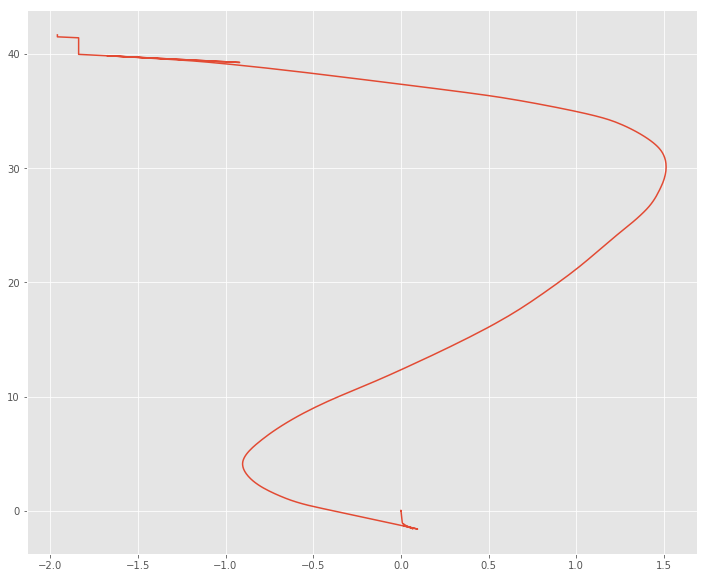

In [18]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
# x = range(24000,25000)
# ax.plot(inds, roll)
# ax.plot(inds,view)
ax.plot(x,y)
# ax.set_aspect('equal')
plt.show()

In [17]:
def get_frames_by_index(camfiles, LUT, index, blank_frame=False, shape=(480,640)):
    lefts = []
    rights = []
    row = LUT.iloc[index,:]
    # t = np.datetime64(row['timestamps'])
    for camname, file in camfiles.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            with h5py.File(file, 'r') as f:
                left = cv2.imdecode(f['left'][camind],0)
                right = cv2.imdecode(f['right'][camind],0)
        else:
            if blank_frame:
                if len(lefts)> 0:
                    left = np.zeros_like(lefts[0])
                    right = np.zeros_like(rights[0])
                else:
                    left = np.zeros(shape, dtype=np.uint8)
                    right = np.zeros(shape, dtype=np.uint8)
            else:
                left, right = None, None
        lefts.append(left)
        rights.append(right)
    return(lefts, rights)

In [25]:
width = 640
height=480
save = False
preview = True
fps = 30
mouse = 'JB042'

In [26]:
N_cams = 4
framesize = (width*4, height*2)

# startind = indices[0]
# endind = indices[-1]
if preview:
#     cv2.namedWindow('Realsense', cv2.WINDOW_AUTOSIZE)
#     cv2.namedWindow('Flea', cv2.WINDOW_AUTOSIZE)
    cv2.namedWindow('Joined', cv2.WINDOW_AUTOSIZE)
    waittime = int(1000/fps)
if save:
    outdir = os.path.join(datadir, 'examples')
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    filename = '%s_%07d_%07d.avi' %(mouse, startind, endind)
    writer = cv2.VideoWriter(os.path.join(outdir, filename),fourcc, fps, framesize)
try:
    oldlefts = [np.zeros((height,width), dtype=np.uint8) for i in range(N_cams)]
    oldrights = [np.zeros((height,width), dtype=np.uint8) for i in range(N_cams)]
    for i in inds:
        t0 = time.perf_counter()
        
        lefts, rights = get_frames_by_index(camfiles, LUT, i, blank_frame=False,
                                           shape=(height,width))
        for j in range(N_cams):
            if lefts[j] is None:
                lefts[j] = oldlefts[j]
            if rights[j] is None:
                rights[j] = oldrights[j]
        
        top = np.hstack(lefts)
        bottom = np.hstack(rights)
        out = np.vstack((top,bottom))

        #         r = np.hstack((r_l, r_r))
        #         f = np.hstack((f_l, f_r))

        #         rheight, rwidth = r.shape
        #         fheight, fwidth = f.shape
        #         out_width = int(fwidth)
        #         out_height = int(fwidth/rwidth*rheight)
        #         out = np.vstack((cv2.resize(r,(out_width,out_height)),
        #                         f))
        oldlefts = lefts
        oldrights = rights
        out = cv2.cvtColor(out, cv2.COLOR_GRAY2RGB)
        text = '%s:%07d' %(mouse, i)
        cv2.putText(out, text, (50,out.shape[0]-50),
                   fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,
                   color=(0,0,255),thickness=1,lineType=cv2.LINE_AA)
        if save:
            writer.write(out)
        print(i)
        if preview:
            # cv2.imshow('Realsense', r)
            # cv2.imshow('Flea',f)
            cv2.imshow('Joined', out)
            elapsed = int((time.perf_counter() - t0)*1000)

            key = cv2.waitKey(max([1,elapsed]))
            if key==27:
                print('User stopped')
                break
                # raise KeyboardInterrupt
except BaseException as e:
    print(e.message)
finally:
    if preview:
        cv2.destroyAllWindows()
    if save:
        writer.release()

1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
User stopped


In [30]:
def fig_to_img(fig_handle):
    # should do nothing if already drawn
    fig_handle.canvas.draw()
    # from stack overflow
    data = np.array(fig_handle.canvas.renderer._renderer)[:,:,0:3]
    return(data)

In [33]:
%matplotlib qt5

In [56]:
preview = True
save = True
animate = True

linelength=2
fontsize=12
fontweight= 'bold'
view = data['position3'][inds]
view = -view
fig = plt.figure(figsize=(16,6))
fig.clf()
# scatters = animation_init()
# anim = FuncAnimation(fig, animate, init_func=animation_init,
#                                frames=len(x), interval=20, blit=True)
ax = [plt.subplot2grid((2,3), (0,0),colspan=3)]
ax += [plt.subplot2grid((2,3), (1,i)) for i in range(3)]

ax[0].plot(y,x)
ax[0].set_aspect('equal')
ax[1].plot(inds,pitch)
ax[2].plot(inds,roll)
ax[3].plot(inds,yaw)
    
scatters = []
scatter, = ax[0].plot(y[0],x[0],'rx')
scatters.append(scatter)

xcomp = np.sin(view)
ycomp = np.cos(view)
# quiver = ax[0].quiver(y[0:1],x[0:1],xcomp[0:1],ycomp[0:1])
startx = x[0]-xcomp[0]*linelength/2
endx =  x[0]+xcomp[0]*linelength/2
starty = y[0] - ycomp[0]*linelength/2
endy = y[0]+ycomp[0]*linelength/2
# this_y = y[0]+ycomp[0]*linelength
line,  = ax[0].plot([starty,endy], [startx,endx],'k-')
linehead, = ax[0].plot(endy, endx, 'ro')

scatter, = ax[1].plot(inds[0],pitch[0],'ro')
scatters.append(scatter)
ax[1].set_ylabel('Pitch', fontsize=fontsize, fontweight=fontweight)

scatter, = ax[2].plot(inds[0],roll[0],'ro')
scatters.append(scatter)
ax[2].set_ylabel('Roll', fontsize=fontsize, fontweight=fontweight)

scatter, = ax[3].plot(inds[0],yaw[0],'ro')
scatters.append(scatter)
ax[3].set_ylabel('Yaw', fontsize=fontsize, fontweight=fontweight)

title = fig.suptitle('T:%04d' %0, fontsize=fontsize+8, fontweight=fontweight)
plt.tight_layout()
if animate:
    for i in range(len(x)):
        start_t = time.perf_counter()
        
        line.set_data([y[i]-ycomp[i]*linelength/2,y[i]+ycomp[i]*linelength/2],
                     [x[i]-xcomp[i]*linelength/2,x[i]+xcomp[i]*linelength/2])
        linehead.set_data(y[i]+ycomp[i]*linelength/2,x[i]+xcomp[i]*linelength/2)
        scatters[0].set_data(y[i], x[i])
        # scatters[0].set_markersize(i)
        scatters[1].set_data(inds[i],pitch[i])
        scatters[2].set_data(inds[i],roll[i])
        scatters[3].set_data(inds[i],yaw[i])
        title.set_text('T:%04d'%i)
        img = fig_to_img(fig)
        if i==0 and save:
            # framesize = img.sha
            outdir = os.path.join(datadir, 'examples')
            if not os.path.isdir(outdir):
                os.makedirs(outdir)
            fourcc = cv2.VideoWriter_fourcc(*'DIVX')
            filename = '%s_virmen_%07d_%07d.avi' %(mouse, inds[0], inds[-1])
            H,W,C = img.shape
            writer = cv2.VideoWriter(os.path.join(outdir, filename),fourcc, fps, (W,H))
        if save:
            writer.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        # plt.draw()
        elapsed = time.perf_counter()-start_t
        plt.pause(0.001)
        
else:
    plt.show()
if save:
    writer.release()
# plt.show()

# Make eye video

In [59]:
eye_inds = LUT['eye'].values[inds]

In [64]:
eyefile = os.path.join(datadir, [i for i in files if i.endswith('eye.avi')][0])

In [73]:
preview = True
save = True

# N_cams = 1
framesize = (640, 512)

startind = int(eye_inds[0])
endind = int(eye_inds[-1])

reader = cv2.VideoCapture(eyefile)
reader.set(cv2.CAP_PROP_POS_FRAMES, startind)

if preview:
#     cv2.namedWindow('Realsense', cv2.WINDOW_AUTOSIZE)
#     cv2.namedWindow('Flea', cv2.WINDOW_AUTOSIZE)
    cv2.namedWindow('Joined', cv2.WINDOW_AUTOSIZE)
    waittime = int(1000/fps)
if save:
    outdir = os.path.join(datadir, 'examples')
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    filename = '%s_%07d_%07d_eyeexample.avi' %(mouse, startind, endind)
    writer = cv2.VideoWriter(os.path.join(outdir, filename),fourcc, fps, framesize)

try:
    for i in range(0,len(eye_inds)):
        t0 = time.perf_counter()
        
        ind = eye_inds[i]
        if np.isnan(ind):
            pass
            # out = np.zeros_like(out)
        else:
            ret, out = reader.read()

        # out = cv2.cvtColor(out, cv2.COLOR_GRAY2RGB)
        text = '%s:%07d' %(mouse, i)
        cv2.putText(out, text, (50,out.shape[0]-50),
                   fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,
                   color=(0,0,255),thickness=1,lineType=cv2.LINE_AA)
        if save:
            writer.write(out)

        if preview:
            # cv2.imshow('Realsense', r)
            # cv2.imshow('Flea',f)
            cv2.imshow('Joined', out)
            elapsed = int((time.perf_counter() - t0)*1000)

            key = cv2.waitKey(max([33,elapsed]))
            if key==27:
                print('User stopped')
                break
                # raise KeyboardInterrupt
except BaseException as e:
    print(e.message)
finally:
    if preview:
        cv2.destroyAllWindows()
    if save:
        writer.release()
    reader.release()

# Make realsense video

In [23]:
files = os.listdir(datadir)
files.sort()
camfiles = {os.path.basename(i)[:-3]: os.path.join(datadir,i) for i in files if i.endswith('t.h5')}

In [26]:
preview = True
save = False
width = 640
height = 480
fps = 30
mouse = 'JB042'

N_cams = 4
framesize = (width*4, height*2)

# startind = indices[0]
# endind = indices[-1]
if preview:
#     cv2.namedWindow('Realsense', cv2.WINDOW_AUTOSIZE)
#     cv2.namedWindow('Flea', cv2.WINDOW_AUTOSIZE)
    cv2.namedWindow('Joined', cv2.WINDOW_AUTOSIZE)
    waittime = int(1000/fps)
if save:
    outdir = os.path.join(datadir, 'examples')
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    filename = '%s_%07d_%07d_realsenseexample.avi' %(mouse, startind, endind)
    writer = cv2.VideoWriter(os.path.join(outdir, filename),fourcc, fps, framesize)
try:
    oldlefts = [np.zeros((height,width), dtype=np.uint8) for i in range(N_cams)]
    oldrights = [np.zeros((height,width), dtype=np.uint8) for i in range(N_cams)]
    for i in inds:
        t0 = time.perf_counter()
        
        lefts, rights = get_frames_by_index(camfiles, LUT, i, blank_frame=False,
                                           shape=(height,width))
        for j in range(N_cams):
            if lefts[j] is None:
                lefts[j] = oldlefts[j]
            if rights[j] is None:
                rights[j] = oldrights[j]
        
        top = np.hstack(lefts)
        bottom = np.hstack(rights)
        out = np.vstack((top,bottom))

        oldlefts = lefts
        oldrights = rights
        out = cv2.cvtColor(out, cv2.COLOR_GRAY2RGB)
        text = '%s:%07d' %(mouse, i)
        cv2.putText(out, text, (50,out.shape[0]-50),
                   fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,
                   color=(0,0,255),thickness=1,lineType=cv2.LINE_AA)
        if save:
            writer.write(out)
        # print(i)
        if preview:
            # cv2.imshow('Realsense', r)
            # cv2.imshow('Flea',f)
            cv2.imshow('Joined', out)
            elapsed = int((time.perf_counter() - t0)*1000)

            key = cv2.waitKey(max([1,elapsed]))
            if key==27:
                print('User stopped')
                break
                # raise KeyboardInterrupt
except BaseException as e:
    print(e.message)
finally:
    if preview:
        cv2.destroyAllWindows()
    if save:
        writer.release()

# Get disparity estimates from file